
## MetObs API key (keep private)
2a0bf9fc-ab9c-4616-bb48-21ca990be16f



# Assignment roadmap
- Scope: compare forecast models vs measured GHI for station 06072; compute RMSE & bias per horizon; produce plots and poster-ready figures.
- Data cadence: forecasts hourly/right-binned; measurements 10 min/right-labeled -> resample to hourly.
- Keys: keep everything in UTC; align on forecast issue time + horizon.



## 1) Measurement data (DMI MetObs)
- Download 10-min GHI for station 06072 via API key; basic QC (BSRN min/max).
- Resample to 1h mean (`df.resample('1H', label='right', closed='right').mean()`).
- Save cleaned hourly series for reuse.



### Load hourly measurements
Load resampled station observations (`station_data_hourly.csv`).


In [21]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

obs_path = Path('station_data_hourly.csv')
obs_hourly = pd.read_csv(obs_path, parse_dates=['time'])

print(f'Loaded {len(obs_hourly)} hourly rows from {obs_path}')
display(obs_hourly.head())


Loaded 408 hourly rows from station_data_hourly.csv


,time,ghi
0,2025-11-08 01:00:00+00:00,0.0
1,2025-11-08 02:00:00+00:00,0.0
2,2025-11-08 03:00:00+00:00,0.0
3,2025-11-08 04:00:00+00:00,0.0
4,2025-11-08 05:00:00+00:00,0.0



## 2) Forecast data (open-meteo files)
- Load all `06072_YYYYMMDDT0600.csv` files; parse `date` as datetime (UTC).
- Long-form melt for stacking models; track forecast issue time for horizons.
- Note model horizons differ (e.g., Harmonie ~54h, ECMWF IFS ~10d).



### Setup
Imports and common paths.


In [22]:
data_dir = Path("ForcastData")
files = sorted(data_dir.glob("06072_*.csv"))
print(f"Found {len(files)} forecast files in {data_dir}")


Found 17 forecast files in ForcastData



### Load all forecasts and reshape
- Load every `06072_YYYYMMDDT0600.csv` in `ForcastData`.
- Add `issue_time` from filename; compute `horizon_hours = date - issue_time`.
- Melt wide model columns into long `model`/`forecast` for easier grouping and metrics.


In [23]:

from typing import List


def issue_from_name(path: Path) -> pd.Timestamp:
    ts = path.stem.split('_')[1]  # e.g., 20251108T0600
    return pd.to_datetime(ts, format="%Y%m%dT%H%M", utc=True)

frames: List[pd.DataFrame] = []
for f in files:
    issue_time = issue_from_name(f)
    df_tmp = pd.read_csv(f, parse_dates=["date"])
    df_tmp["issue_time"] = issue_time
    df_tmp["horizon_hours"] = (df_tmp["date"] - df_tmp["issue_time"]).dt.total_seconds() / 3600
    long_tmp = df_tmp.melt(
        id_vars=["date", "issue_time", "horizon_hours"],
        var_name="model",
        value_name="forecast"
    )
    long_tmp["source_file"] = f.name
    frames.append(long_tmp)

all_forecasts = pd.concat(frames, ignore_index=True)
print("Loaded rows:", len(all_forecasts))
display(all_forecasts.head())

# Quick check: max horizon per model to understand coverage
max_h = all_forecasts.groupby("model")["horizon_hours"].max().sort_values()
print("\nMax horizon (hours) per model:\n", max_h)


Loaded rows: 22848


,date,issue_time,horizon_hours,model,forecast,source_file
0,2025-11-08 00:00:00+00:00,2025-11-08 06:00:00+00:00,-6.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
1,2025-11-08 01:00:00+00:00,2025-11-08 06:00:00+00:00,-5.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
2,2025-11-08 02:00:00+00:00,2025-11-08 06:00:00+00:00,-4.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
3,2025-11-08 03:00:00+00:00,2025-11-08 06:00:00+00:00,-3.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv
4,2025-11-08 04:00:00+00:00,2025-11-08 06:00:00+00:00,-2.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv



Max horizon (hours) per model:
 model
dmi_harmonie_arome_europe    161.0
dmi_seamless                 161.0
ecmwf_aifs025_single         161.0
ecmwf_ifs                    161.0
ecmwf_ifs025                 161.0
gfs_global                   161.0
gfs_seamless                 161.0
metno_nordic                 161.0
Name: horizon_hours, dtype: float64



### Quick single-file preview & plot
Plot one forecast file to see model shapes.


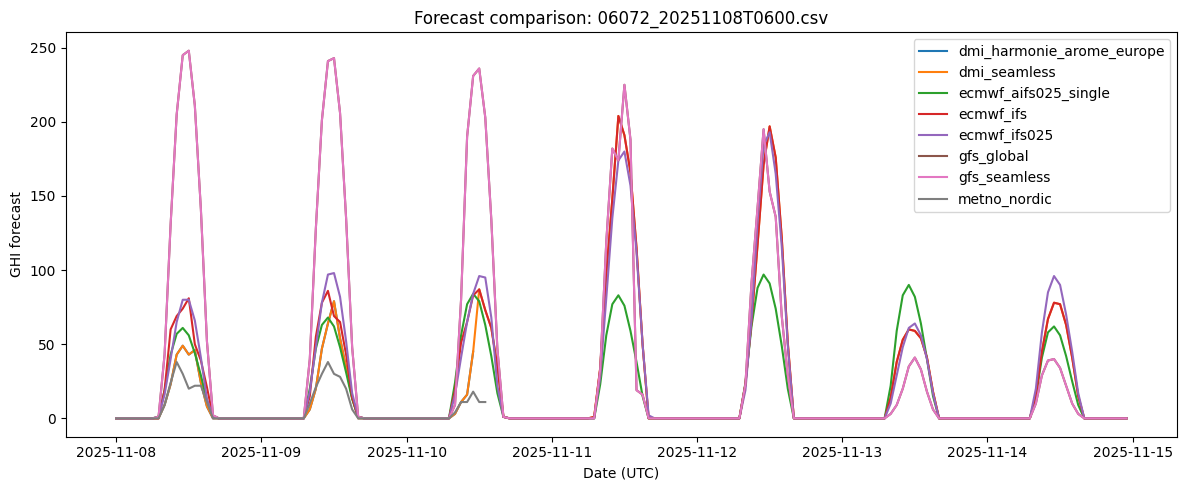

In [24]:

if not files:
    raise ValueError("No forecast files found")

first_file = files[0] # write 0-10 to plot the diffrent files
df_single = pd.read_csv(first_file, parse_dates=["date"])
long_single = df_single.melt(id_vars="date", var_name="model", value_name="forecast")

plt.figure(figsize=(12, 5))
for model, grp in long_single.groupby("model"):
    plt.plot(grp["date"], grp["forecast"], label=model, linewidth=1.5)

plt.xlabel("Date (UTC)")
plt.ylabel("GHI forecast")
plt.title(f"Forecast comparison: {first_file.name}")
plt.legend()
plt.tight_layout()
plt.show()



## 3) Align forecasts vs measurements
- Build forecast horizon `h = date - issue_time` per file; drop negative/NaN.
- Inner-join forecasts with hourly measurements on timestamp.
- Ensure right-edge alignment: forecast hour 02:00 covers 01:01-02:00.



### Align forecasts with measurements
Join forecasts to hourly observations on timestamp and filter valid horizons.


In [25]:

# Prepare observations with a matching timestamp column
obs_ready = obs_hourly.rename(columns={'time': 'date'}).copy()
obs_ready['date'] = pd.to_datetime(obs_ready['date'], utc=True)
obs_ready = obs_ready[['date', 'ghi']]

# Join forecasts with observations on timestamp
aligned = all_forecasts.merge(obs_ready, on='date', how='inner')

# Keep only non-negative horizons and valid values
aligned = aligned[aligned['horizon_hours'] >= 0].dropna(subset=['forecast', 'ghi']).copy()
aligned['error'] = aligned['forecast'] - aligned['ghi']

print(f"Aligned rows: {len(aligned)}")
print(aligned[['model', 'horizon_hours']].groupby('model').size().head())
display(aligned.head())


# Model coverage check
model_counts = aligned.groupby("model").size().sort_values(ascending=False)
print("Rows per model (top 10):", model_counts.head(10))
unique_models = aligned["model"].unique()
print(f"Total models in aligned data: {len(unique_models)} -> {sorted(unique_models)[:5]} ...")


Aligned rows: 14366
model
dmi_harmonie_arome_europe     818
dmi_seamless                 2117
ecmwf_aifs025_single         2117
ecmwf_ifs                    2117
ecmwf_ifs025                 2117
dtype: int64


,date,issue_time,horizon_hours,model,forecast,source_file,ghi,error
5,2025-11-08 06:00:00+00:00,2025-11-08 06:00:00+00:00,0.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.000000,0.000000
6,2025-11-08 07:00:00+00:00,2025-11-08 06:00:00+00:00,1.0,dmi_harmonie_arome_europe,0.0,06072_20251108T0600.csv,0.500000,-0.500000
7,2025-11-08 08:00:00+00:00,2025-11-08 06:00:00+00:00,2.0,dmi_harmonie_arome_europe,9.0,06072_20251108T0600.csv,7.000000,2.000000
8,2025-11-08 09:00:00+00:00,2025-11-08 06:00:00+00:00,3.0,dmi_harmonie_arome_europe,23.0,06072_20251108T0600.csv,19.666667,3.333333
9,2025-11-08 10:00:00+00:00,2025-11-08 06:00:00+00:00,4.0,dmi_harmonie_arome_europe,43.0,06072_20251108T0600.csv,29.166667,13.833333


Rows per model (top 10): model
dmi_seamless                 2117
ecmwf_aifs025_single         2117
ecmwf_ifs                    2117
ecmwf_ifs025                 2117
gfs_global                   2117
gfs_seamless                 2117
metno_nordic                  846
dmi_harmonie_arome_europe     818
dtype: int64
Total models in aligned data: 8 -> ['dmi_harmonie_arome_europe', 'dmi_seamless', 'ecmwf_aifs025_single', 'ecmwf_ifs', 'ecmwf_ifs025'] ...



## 4) Exploratory plots
- For a single day: plot measured vs each model to see timing/shape.
- Add scatter of forecast vs measured for a chosen horizon (e.g., 24h).
- Inspect diurnal bias or cloud-related misses.



## 5) Error metrics by horizon
- Compute RMSE and bias per model per horizon across all files.
- Visualize RMSE(h) and bias(h) curves; highlight best-performing model per horizon.
- Summaries: table of RMSE/Bias for 24h, 48h, 72h, etc.



### Error metrics by horizon
Compute RMSE and bias per model and horizon; plot curves and key horizons (24/48/72h).


In [26]:
GHI_MIN = 0.1  # GHI threshold for daylight filtering (W/m^2)


In [27]:

import numpy as np
import pandas as pd

def metrics_with_nrmse(df, group_keys, ghi_min=GHI_MIN):
    'Compute RMSE/Bias/NRMSE with a daylight filter to avoid divide-by-zero.'
    df = df[df['ghi'] > ghi_min].copy()
    if df.empty:
        return pd.DataFrame(columns=list(group_keys) + ['rmse', 'bias', 'n', 'obs_mean', 'nrmse'])
    agg = df.groupby(group_keys).agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean'),
        n=('error', 'size'),
        obs_mean=('ghi', 'mean')
    ).reset_index()
    agg['nrmse'] = np.where(agg['obs_mean'] > 0, agg['rmse'] / agg['obs_mean'], np.nan)
    return agg


Using forecast file: 06072_20251108T0600.csv


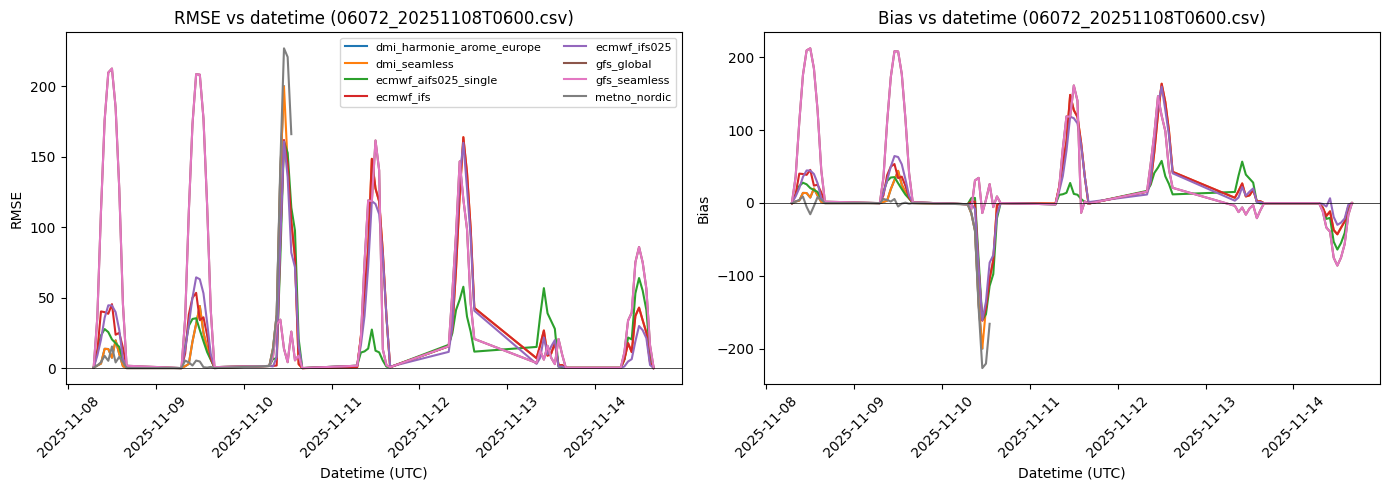

RMSE/Bias/NRMSE at key horizons (rows=model, cols=horizon) for 06072_20251108T0600.csv


model


In [28]:
import numpy as np

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Choose which forecast file to analyze (by index in files)
selected_idx = 0  # change to another index to pick a different file
if not files:
    raise ValueError("No forecast files loaded in files")
selected_file = files[selected_idx].name
print(f"Using forecast file: {selected_file}")

aligned_sel = aligned[aligned['source_file'] == selected_file].copy()
if aligned_sel.empty:
    raise ValueError(f"No aligned rows found for {selected_file}; check selection")

# Compute RMSE, bias, NRMSE per model per timestamp (datetime) with daylight filter
tagged = metrics_with_nrmse(aligned_sel, ['model', 'date'], ghi_min=GHI_MIN)

# Plot RMSE and bias vs datetime
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)
for model, grp in tagged.groupby('model'):
    axes[0].plot(grp['date'], grp['rmse'], label=model)
    axes[1].plot(grp['date'], grp['bias'], label=model)
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('Bias')
for ax in axes:
    ax.set_xlabel('Datetime (UTC)')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.tick_params(axis='x', rotation=45)
axes[0].set_title(f'RMSE vs datetime ({selected_file})')
axes[1].set_title(f'Bias vs datetime ({selected_file})')
axes[0].legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

# Summaries at key horizons (keep table for reference)
aligned_sel['h_bin'] = aligned_sel['horizon_hours'].round(0)
key_h = [24, 48, 72]
agg_h = metrics_with_nrmse(aligned_sel, ['model', 'h_bin'], ghi_min=GHI_MIN)
summary = agg_h[agg_h['h_bin'].isin(key_h)].pivot(index='model', columns='h_bin', values=['rmse', 'bias', 'nrmse'])
print('RMSE/Bias/NRMSE at key horizons (rows=model, cols=horizon) for', selected_file)
display(summary)



### Average RMSE and bias per model (selected file)


In [29]:

if 'aligned_sel' not in locals():
    raise ValueError("Run the metrics cell above first to set aligned_sel")

avg_metrics = metrics_with_nrmse(aligned_sel, ['model'], ghi_min=GHI_MIN).rename(columns={'rmse': 'rmse_avg', 'bias': 'bias_avg', 'nrmse': 'nrmse_avg'})

print(f"Average RMSE/Bias/NRMSE for {selected_file} (all horizons, daylight filter)")
display(avg_metrics.sort_values('nrmse_avg'))


Average RMSE/Bias/NRMSE for 06072_20251108T0600.csv (all horizons, daylight filter)


,model,rmse_avg,bias_avg,n,obs_mean,nrmse_avg
2,ecmwf_aifs025_single,42.225722,0.159204,67,41.840796,1.009200
4,ecmwf_ifs025,57.984658,18.338308,67,41.840796,1.385840
3,ecmwf_ifs,60.773797,17.577114,67,41.840796,1.452501
1,dmi_seamless,62.406122,11.308458,67,41.840796,1.491514
0,dmi_harmonie_arome_europe,51.460071,-7.060000,25,32.580000,1.579499
7,metno_nordic,74.731433,-29.561728,27,45.302469,1.649611
5,gfs_global,89.172881,44.711443,67,41.840796,2.131242
6,gfs_seamless,89.172881,44.711443,67,41.840796,2.131242



### Average RMSE and bias per model (all forecast files)


In [30]:

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

avg_all = metrics_with_nrmse(aligned, ['model'], ghi_min=GHI_MIN).rename(columns={'rmse': 'rmse_avg', 'bias': 'bias_avg', 'nrmse': 'nrmse_avg'})

print("Average RMSE/Bias/NRMSE across all forecast files (all horizons, daylight filter)")
display(avg_all.sort_values('nrmse_avg'))


Average RMSE/Bias/NRMSE across all forecast files (all horizons, daylight filter)


,model,rmse_avg,bias_avg,n,obs_mean,nrmse_avg
4,ecmwf_ifs025,35.443338,6.060676,868,69.279186,0.511602
3,ecmwf_ifs,36.709505,9.322197,868,69.279186,0.529878
1,dmi_seamless,39.695285,5.356759,868,69.279186,0.572976
7,metno_nordic,40.592034,-7.664069,385,69.321212,0.585564
0,dmi_harmonie_arome_europe,40.217894,-3.274043,357,65.937908,0.609936
2,ecmwf_aifs025_single,42.778910,-17.396697,868,69.279186,0.617486
5,gfs_global,52.080874,-2.820661,868,69.279186,0.751754
6,gfs_seamless,52.080874,-2.820661,868,69.279186,0.751754



## 6) Blended forecast attempt
- Try weighted blend (e.g., 80/20 or simple average of top models).
- Optimize weights on a validation slice; compare RMSE/Bias vs best single model.
- Keep method simple and reproducible.



### Blended forecast (top 2 models)
Simple weight search on the two lowest-RMSE models from the selected file.



## 7) Poster-ready figures & notes
- Key plots: forecast vs measurement (one representative day); RMSE/Bias vs horizon.
- Brief bullets on why certain models perform better; note limitations.
- Include method steps, data sources, and time labels (UTC, right-binned).



### Blended forecast across all files
Simple weight search on two models using all aligned data (not just selected file).


In [31]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# --- Config: choose models and weights ---
# Provide exactly two models or leave empty to auto-pick lowest RMSE from avg_all
selected_models_all = ['ecmwf_ifs', 'ecmwf_aifs025_single']  # e.g., ['ecmwf_ifs', 'dmi_harmonie_arome_europe']
weight_grid_all = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# Optional filters
h_range_all = None          # e.g., (0, 72)
date_range_all = None       # e.g., ('2025-11-09', '2025-11-12')
# ----------------------------------------

work_all = aligned.copy()
if h_range_all:
    hmin, hmax = h_range_all
    work_all = work_all[(work_all['horizon_hours'] >= hmin) & (work_all['horizon_hours'] <= hmax)]
if date_range_all:
    d0 = pd.to_datetime(date_range_all[0])
    d1 = pd.to_datetime(date_range_all[1])
    work_all = work_all[(work_all['date'] >= d0) & (work_all['date'] <= d1)]

if work_all.empty:
    raise ValueError("No data after applying filters; adjust h_range_all/date_range_all")

# choose models
if selected_models_all:
    if len(selected_models_all) != 2:
        raise ValueError("Provide exactly two models in selected_models_all or leave empty")
    top_models_all = selected_models_all
else:
    if 'avg_all' not in locals():
        raise ValueError("Run the overall average metrics cell to populate avg_all")
    top_models_all = avg_all['model'].head(2).tolist()

wide_all = work_all[work_all['model'].isin(top_models_all)].pivot_table(
    index=['date', 'horizon_hours'], columns='model', values='forecast'
)
wide_all = wide_all.dropna()
wide_all = wide_all.join(work_all.set_index(['date', 'horizon_hours'])['ghi']).dropna()

if wide_all.empty:
    raise ValueError("No overlapping data for chosen models/filters; adjust selections")

obs = wide_all['ghi'].values
best = {'w': None, 'rmse': np.inf, 'bias': None}

for w in weight_grid_all:
    blend = w * wide_all[top_models_all[0]] + (1 - w) * wide_all[top_models_all[1]]
    err = blend - obs
    rmse = np.sqrt((err**2).mean())
    bias = err.mean()
    if rmse < best['rmse']:
        best = {'w': w, 'rmse': rmse, 'bias': bias}

blend_label = f"blend {top_models_all[0]}:{best['w']:.2f} / {top_models_all[1]}:{1-best['w']:.2f}"

# compare against best single model overall
best_single_all = avg_all.iloc[0]['model'] if 'avg_all' in locals() else None
rows = [{'model': blend_label, 'rmse': best['rmse'], 'bias': best['bias']}]
if best_single_all:
    single_err_all = work_all[work_all['model'] == best_single_all]['error']
    if not single_err_all.empty:
        rows.append({
            'model': best_single_all,
            'rmse': np.sqrt((single_err_all**2).mean()),
            'bias': single_err_all.mean()
        })

compare_all = pd.DataFrame(rows)
print(f"Using {len(work_all)} points across all files; models: {top_models_all}")
print(f"Blended weight for {top_models_all[0]}: {best['w']:.2f}, {top_models_all[1]}: {1-best['w']:.2f}")
display(compare_all)


Using 14366 points across all files; models: ['ecmwf_ifs', 'ecmwf_aifs025_single']
Blended weight for ecmwf_ifs: 0.60, ecmwf_aifs025_single: 0.40


,model,rmse,bias
0,blend ecmwf_ifs:0.60 / ecmwf_aifs025_single:0.40,20.715473,-0.603835
1,dmi_harmonie_arome_europe,26.569096,-1.428892



### RMSE vs lead time (1-7 days)
Average RMSE/bias per model when truncating horizons to 1-7 days ahead (uses all files; sample size varies by model/day).


In [32]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# baselines over all horizons
baseline = aligned.groupby('model').agg(
    rmse_all=('error', lambda x: np.sqrt((x**2).mean())),
    bias_all=('error', 'mean')
).reset_index()

rows = []
for days in [7,6,5,4,3,2,1]:
    h_max = days * 24
    subset = aligned[aligned['horizon_hours'] <= h_max]
    if subset.empty:
        continue
    agg = subset.groupby('model').agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean'),
        n=('error', 'size')
    ).reset_index()
    agg['days_ahead'] = days
    rows.append(agg)

if not rows:
    raise ValueError("No data for requested day horizons")

results = pd.concat(rows, ignore_index=True)
results = results.merge(baseline, on='model', how='left')
results['rmse_delta'] = results['rmse'] - results['rmse_all']
results['bias_delta'] = results['bias'] - results['bias_all']

# tidy display: smaller days first
results = results.sort_values(['model','days_ahead'], ascending=[True, False])

print("RMSE/Bias by max lead (days), compared to full-horizon baseline (rmse_delta <0 means improvement)")
display(results[['model','days_ahead','rmse','bias','n','rmse_delta','bias_delta']])


RMSE/Bias by max lead (days), compared to full-horizon baseline (rmse_delta <0 means improvement)


,model,days_ahead,rmse,bias,n,rmse_delta,bias_delta
0,dmi_harmonie_arome_europe,7,26.569096,-1.428892,818,0.000000,0.000000
8,dmi_harmonie_arome_europe,6,26.569096,-1.428892,818,0.000000,0.000000
16,dmi_harmonie_arome_europe,5,26.569096,-1.428892,818,0.000000,0.000000
24,dmi_harmonie_arome_europe,4,26.569096,-1.428892,818,0.000000,0.000000
32,dmi_harmonie_arome_europe,3,26.569096,-1.428892,818,0.000000,0.000000
40,dmi_harmonie_arome_europe,2,22.074225,-1.146279,748,-4.494872,0.282613
48,dmi_harmonie_arome_europe,1,23.460555,0.068528,394,-3.108542,1.497420
1,dmi_seamless,7,25.417823,2.196347,2117,0.000000,0.000000
9,dmi_seamless,6,25.604074,2.137694,1930,0.186251,-0.058653
17,dmi_seamless,5,25.781887,1.788415,1666,0.364063,-0.407932



### Blend comparison by lead time
Grid-search blend of two chosen models across 1-7 day horizons; reports best weight and RMSE/Bias per lead.


In [33]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# --- Config ---
blend_models = ['ecmwf_ifs', 'ecmwf_aifs025_single']  # e.g., ['ecmwf_ifs', 'dmi_seamless']; leave empty to auto-pick top 2 from avg_all
weight_grid = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lead_days = [7, 6, 5, 4, 3, 2, 1]
# --------------

# choose models
if blend_models:
    if len(blend_models) != 2:
        raise ValueError("Provide exactly two models in blend_models")
    models_use = blend_models
else:
    if 'avg_all' not in locals():
        raise ValueError("Run the overall average metrics cell to populate avg_all")
    models_use = avg_all['model'].head(2).tolist()

rows = []
for days in lead_days:
    h_max = days * 24
    subset = aligned[aligned['horizon_hours'] <= h_max]
    subset = subset[subset['model'].isin(models_use)].copy()
    if subset.empty:
        continue
    wide = subset.pivot_table(index=['date', 'horizon_hours'], columns='model', values='forecast')
    wide = wide.dropna()
    wide = wide.join(subset.set_index(['date', 'horizon_hours'])['ghi']).dropna()
    if wide.empty:
        continue
    obs = wide['ghi'].values
    best = {'w': None, 'rmse': np.inf, 'bias': None}
    for w in weight_grid:
        blend = w * wide[models_use[0]] + (1 - w) * wide[models_use[1]]
        err = blend - obs
        rmse = np.sqrt((err**2).mean())
        bias = err.mean()
        if rmse < best['rmse']:
            best = {'w': w, 'rmse': rmse, 'bias': bias}
    rows.append({
        'days_ahead': days,
        'model': f"blend {models_use[0]}:{best['w']:.2f}/{models_use[1]}:{1-best['w']:.2f}",
        'rmse': best['rmse'],
        'bias': best['bias'],
        'n': len(wide)
    })

if not rows:
    raise ValueError("No data for requested lead days/models")

results = pd.DataFrame(rows).sort_values('days_ahead', ascending=False)
print(f"Blend lead-time results for models: {models_use}")
display(results)


Blend lead-time results for models: ['ecmwf_ifs', 'ecmwf_aifs025_single']


,days_ahead,model,rmse,bias,n
0,7,blend ecmwf_ifs:0.60/ecmwf_aifs025_single:0.40,20.688253,-0.559817,4234
1,6,blend ecmwf_ifs:0.60/ecmwf_aifs025_single:0.40,20.365540,-0.199715,3860
2,5,blend ecmwf_ifs:0.60/ecmwf_aifs025_single:0.40,20.413904,-0.017107,3332
3,4,blend ecmwf_ifs:0.60/ecmwf_aifs025_single:0.40,20.060229,-0.103769,2768
4,3,blend ecmwf_ifs:0.70/ecmwf_aifs025_single:0.30,19.470749,-0.027953,2156
5,2,blend ecmwf_ifs:0.80/ecmwf_aifs025_single:0.20,16.923260,0.924844,1496
6,1,blend ecmwf_ifs:0.80/ecmwf_aifs025_single:0.20,17.233550,1.020812,788



### Day-specific forecast accuracy
Compare RMSE/bias for specific lead days (e.g., day 1 vs day 7) across all forecast files.


In [34]:

import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# Configure which lead days to evaluate (1 = 0-24h, 2 = 24-48h, etc.)
target_days = [1, 2, 3, 4, 5, 6, 7]

rows = []
for d in target_days:
    h_low = (d - 1) * 24
    h_high = d * 24
    subset = aligned[(aligned['horizon_hours'] > h_low) & (aligned['horizon_hours'] <= h_high)]
    if subset.empty:
        continue
    agg = metrics_with_nrmse(subset, ['model'], ghi_min=GHI_MIN)
    agg['day'] = d
    rows.append(agg.rename(columns={'nrmse': 'nrmse'}))

if not rows:
    raise ValueError('No data for selected target_days')

results = pd.concat(rows, ignore_index=True)

print("RMSE/Bias/NRMSE by specific lead day (across all files; day 1 = 0-24h, day 7 = 144-168h)")
display(results.pivot(index='model', columns='day', values='nrmse'))


RMSE/Bias/NRMSE by specific lead day (across all files; day 1 = 0-24h, day 7 = 144-168h)


day,1,2,3,4,5,6,7
model,,,,,,,
dmi_harmonie_arome_europe,0.603560,0.476661,0.829107,NaN,NaN,NaN,NaN
dmi_seamless,0.603560,0.476661,0.721369,0.678164,0.565624,0.505431,0.409497
ecmwf_aifs025_single,0.618945,0.614906,0.604254,0.544704,0.611696,0.617352,0.684716
ecmwf_ifs,0.462087,0.419603,0.627272,0.678164,0.565624,0.505431,0.409497
ecmwf_ifs025,0.491022,0.421516,0.585336,0.624456,0.550351,0.490008,0.390875
gfs_global,0.860110,0.702887,0.622202,0.714054,0.654975,0.695789,0.939931
gfs_seamless,0.860110,0.702887,0.622202,0.714054,0.654975,0.695789,0.939931
metno_nordic,0.532206,0.489687,0.703090,NaN,NaN,NaN,NaN



### Day-specific RMSE/Bias plot
Visualize RMSE and Bias by day horizon (day 1 = 0-24h, ..., day 7 = 144-168h).


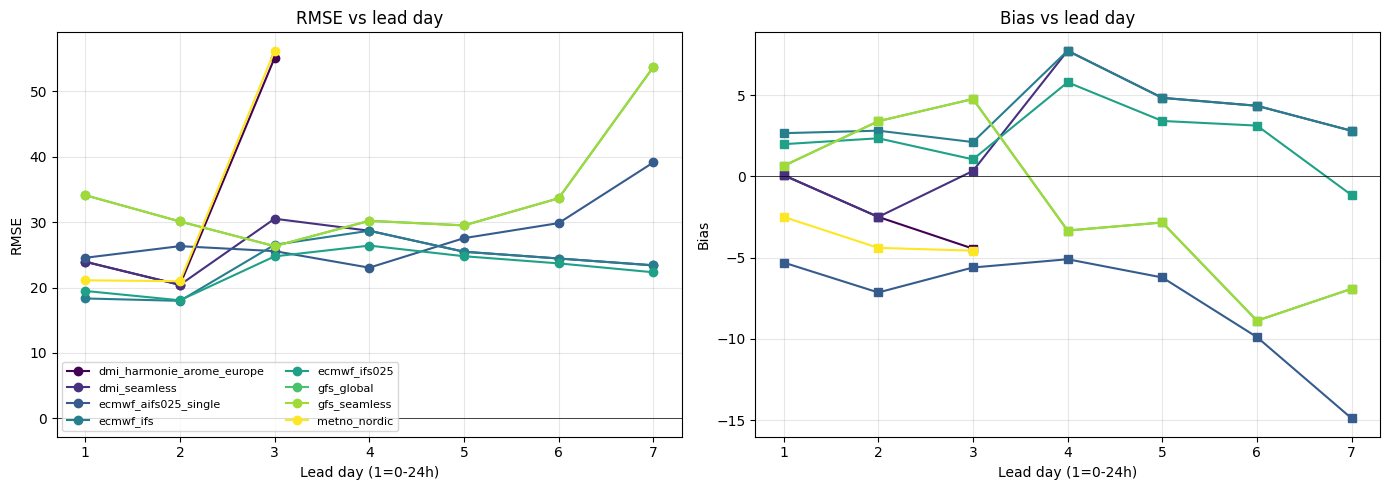

In [35]:
import numpy as np
import pandas as pd

if 'aligned' not in locals() or aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

# same config as table
plot_days = [1, 2, 3, 4, 5, 6, 7]

rows = []
for d in plot_days:
    h_low = (d - 1) * 24
    h_high = d * 24
    subset = aligned[(aligned['horizon_hours'] > h_low) & (aligned['horizon_hours'] <= h_high)]
    if subset.empty:
        continue
    agg = subset.groupby('model').agg(
        rmse=('error', lambda x: np.sqrt((x**2).mean())),
        bias=('error', 'mean'),
        obs_mean=('ghi', 'mean')
    ).reset_index()
    agg['day'] = d
    agg['nrmse'] = agg['rmse'] / agg['obs_mean']
    rows.append(agg)

if not rows:
    raise ValueError('No data for selected plot_days')

results = pd.concat(rows, ignore_index=True)

# color map setup
cmap = plt.get_cmap('viridis')
models = sorted(results['model'].unique())
if len(models) > 1:
    cmap_vals = cmap(np.linspace(0.0, 1.0, len(models)))
else:
    cmap_vals = [cmap(0.5)]
color_map = {m: c for m, c in zip(models, cmap_vals)}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
for model, grp in results.groupby('model'):
    axes[0].plot(grp['day'], grp['rmse'], label=model, color=color_map[model], marker='o', linewidth=1.5)
    axes[1].plot(grp['day'], grp['bias'], label=model, color=color_map[model], marker='s', linewidth=1.5)
axes[0].set_xlabel('Lead day (1=0-24h)')
axes[1].set_xlabel('Lead day (1=0-24h)')
axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('Bias')
for ax in axes:
    ax.axhline(0, color='k', linewidth=0.5)
    ax.grid(alpha=0.3)
axes[0].set_title('RMSE vs lead day')
axes[1].set_title('Bias vs lead day')
axes[0].legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


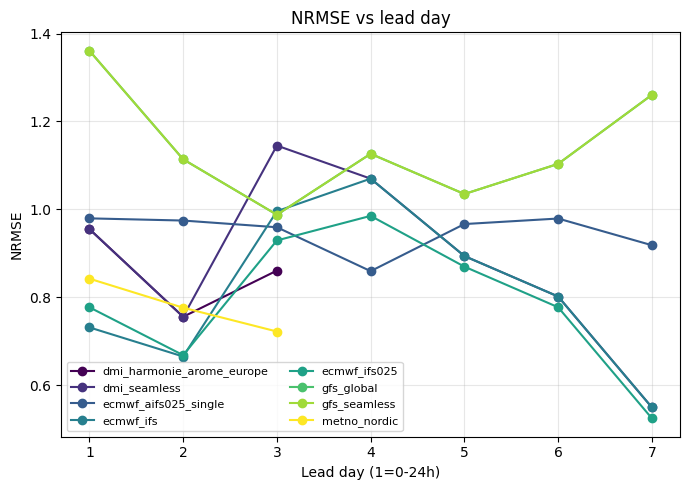

In [36]:

import numpy as np

if 'results' not in locals() or results.empty:
    raise ValueError('Run the lead-day RMSE/Bias cell first to build results')
if 'nrmse' not in results.columns:
    raise ValueError('results is missing nrmse; rerun the RMSE/Bias cell')

# colormap setup
cmap = plt.get_cmap('viridis')
models = sorted(results['model'].unique())
if len(models) > 1:
    cmap_vals = cmap(np.linspace(0.0, 1.0, len(models)))
else:
    cmap_vals = [cmap(0.5)]
color_map = {m: c for m, c in zip(models, cmap_vals)}

fig, ax = plt.subplots(figsize=(7, 5))
for model, grp in results.groupby('model'):
    ax.plot(grp['day'], grp['nrmse'], marker='o', label=model, color=color_map[model])
ax.set_xlabel('Lead day (1=0-24h)')
ax.set_ylabel('NRMSE')
ax.set_title('NRMSE vs lead day')
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



### Debug: inspect forecast dataframe for a day/model


In [37]:

import numpy as np
import pandas as pd

# Adjust as needed
model_focus = 'ecmwf_ifs'
target_day = pd.to_datetime('2025-11-18', utc=True)

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

fc_day = aligned[(aligned['date'].dt.floor('D') == target_day)].copy()
if model_focus:
    fc_day = fc_day[fc_day['model'] == model_focus]

fc_day['h_bin'] = fc_day['horizon_hours'].round(0)
print("Rows:", len(fc_day))
print("Models present:", fc_day['model'].unique())
print("Horizon bins (sorted):", sorted(fc_day['h_bin'].unique()))
print("Sample rows:")
display(fc_day[['date','issue_time','horizon_hours','h_bin','model','forecast','ghi']].head(30))


Rows: 162
Models present: ['ecmwf_ifs']
Horizon bins (sorted): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149

,date,issue_time,horizon_hours,h_bin,model,forecast,ghi
6352,2025-11-18 00:00:00+00:00,2025-11-12 06:00:00+00:00,138.0,138.0,ecmwf_ifs,0.0,0.000000
6353,2025-11-18 01:00:00+00:00,2025-11-12 06:00:00+00:00,139.0,139.0,ecmwf_ifs,0.0,0.000000
6354,2025-11-18 02:00:00+00:00,2025-11-12 06:00:00+00:00,140.0,140.0,ecmwf_ifs,0.0,0.000000
6355,2025-11-18 03:00:00+00:00,2025-11-12 06:00:00+00:00,141.0,141.0,ecmwf_ifs,0.0,0.000000
6356,2025-11-18 04:00:00+00:00,2025-11-12 06:00:00+00:00,142.0,142.0,ecmwf_ifs,0.0,0.000000
6357,2025-11-18 05:00:00+00:00,2025-11-12 06:00:00+00:00,143.0,143.0,ecmwf_ifs,0.0,0.000000
6358,2025-11-18 06:00:00+00:00,2025-11-12 06:00:00+00:00,144.0,144.0,ecmwf_ifs,0.0,0.000000
6359,2025-11-18 07:00:00+00:00,2025-11-12 06:00:00+00:00,145.0,145.0,ecmwf_ifs,0.0,0.333333
6360,2025-11-18 08:00:00+00:00,2025-11-12 06:00:00+00:00,146.0,146.0,ecmwf_ifs,27.0,23.000000
6361,2025-11-18 09:00:00+00:00,2025-11-12 06:00:00+00:00,147.0,147.0,ecmwf_ifs,94.0,70.000000



### Build daily dataframe with obs + 1-7 day horizons (one model)
Creates a table for a target day where each column is forecast from a different issue date (1..7 days ahead).


In [38]:
import pandas as pd
from pathlib import Path

models_focus = ['ecmwf_ifs', 'ecmwf_aifs025_single']  # pick any two (or more) models you want to compare
target_day = pd.to_datetime('2025-11-19', utc=True)  # day you want to evaluate (UTC, date only)
data_dir = Path('ForcastData')

def issue_from_name(path: Path) -> pd.Timestamp:
    ts = path.stem.split('_')[1]  # e.g., 20251118T0600
    return pd.to_datetime(ts, format='%Y%m%dT%H%M', utc=True)

def load_file(path: Path):
    df = pd.read_csv(path, parse_dates=['date'])
    df['issue_time'] = issue_from_name(path)
    df['horizon_hours'] = (df['date'] - df['issue_time']).dt.total_seconds() / 3600
    return df

def build_daily_result(model_focus: str, target_day: pd.Timestamp) -> pd.DataFrame:
    obs_day = obs_ready[obs_ready['date'].dt.floor('D') == target_day].copy()
    if obs_day.empty:
        raise ValueError(f"No observations for {target_day.date()}")
    result = pd.DataFrame({'date': obs_day['date'], 'obs_ghi': obs_day['ghi']}).set_index('date')

    for k in range(1, 8):
        issue_day = (target_day - pd.Timedelta(days=k)).strftime('%Y%m%dT0600')
        fname = f"06072_{issue_day}.csv"
        fpath = data_dir / fname
        if not fpath.exists():
            print(f"Missing forecast file for {k}d horizon: {fname}")
            continue
        df = load_file(fpath)
        df = df[['date', model_focus]].rename(columns={model_focus: f'h{k}d'})
        df = df[df['date'].dt.floor('D') == target_day].set_index('date')
        result = result.join(df, how='left')

    return result.reset_index()

results = {m: build_daily_result(m, target_day) for m in models_focus}
print(f"Built daily data for {target_day.date()} â€” models: {list(results)}")
for m, df in results.items():
    print(m, df.shape)
    display(df.head(5))


Built daily data for 2025-11-19 â€” models: ['ecmwf_ifs', 'ecmwf_aifs025_single']
ecmwf_ifs (24, 9)


,date,obs_ghi,h1d,h2d,h3d,h4d,h5d,h6d,h7d
0,2025-11-19 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2025-11-19 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2025-11-19 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2025-11-19 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,2025-11-19 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


ecmwf_aifs025_single (24, 9)


,date,obs_ghi,h1d,h2d,h3d,h4d,h5d,h6d,h7d
0,2025-11-19 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2025-11-19 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2025-11-19 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,2025-11-19 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,2025-11-19 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN



### Plot daily obs vs 1-7 day forecasts


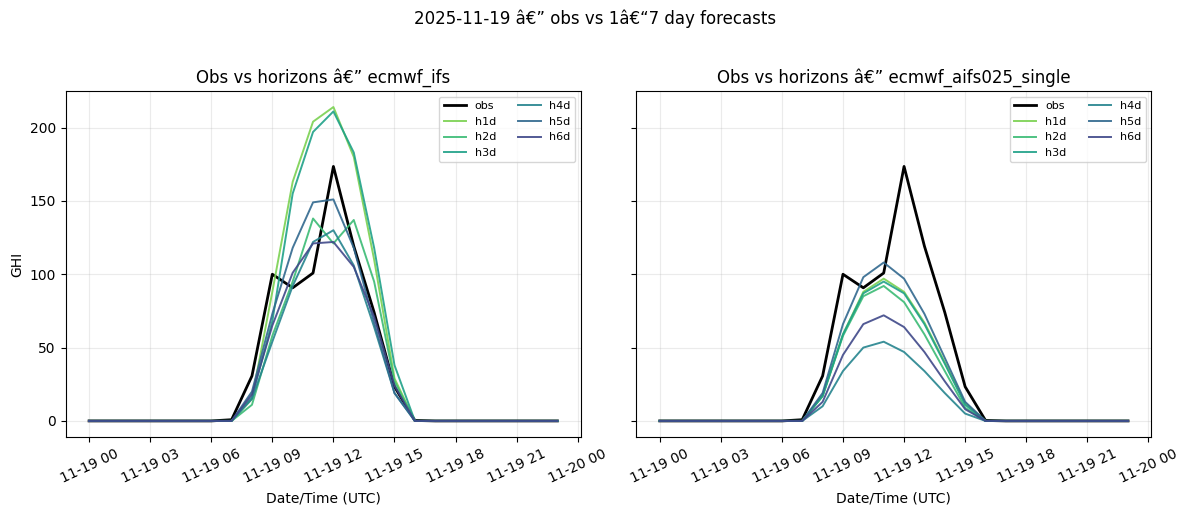

In [39]:
import numpy as np
import matplotlib.pyplot as plt

if not results:
    raise ValueError("No results built; run the daily dataframe cell first.")

fig, axes = plt.subplots(1, len(results), figsize=(6 * len(results), 5), sharex=True, sharey=True)
if len(results) == 1:
    axes = [axes]

cmap = plt.get_cmap('viridis')

for ax, (model_name, df) in zip(axes, results.items()):
    horizon_cols = sorted([c for c in df.columns if c.startswith('h') and c.endswith('d')], key=lambda c: int(c[1:-1]))
    colors = cmap(np.linspace(0.8, 0.1, len(horizon_cols)))

    ax.plot(df['date'], df['obs_ghi'], label='obs', color='black', linewidth=2)
    for col, colc in zip(horizon_cols, colors):
        if not df[col].notna().any():
            continue
        ax.plot(df['date'], df[col], label=col, color=colc, alpha=0.9, linewidth=1.4)

    ax.set_title(f'Obs vs horizons â€” {model_name}')
    ax.set_xlabel('Date/Time (UTC)')
    ax.tick_params(axis='x', rotation=25)
    ax.legend(fontsize=8, ncol=2)
    ax.grid(alpha=0.25)

axes[0].set_ylabel('GHI')
fig.suptitle(f'{target_day.date()} â€” obs vs 1â€“7 day forecasts', y=1.02)
plt.tight_layout()
plt.show()



### Normalized RMSE (NRMSE)
NRMSE = RMSE divided by mean observed GHI (overall and at key horizons 24/48/72h).


In [40]:

import numpy as np
import pandas as pd

if aligned.empty:
    raise ValueError("Run the alignment cell first to build 'aligned'")

obs_mean = aligned[aligned['ghi'] > 5]['ghi'].mean()
print(f"Mean observed GHI (daylight filter >5): {obs_mean:.3f}")

# Overall NRMSE per model (daylight filtered)
agg_overall = metrics_with_nrmse(aligned, ['model'], ghi_min=GHI_MIN)
print("Overall RMSE / Bias / NRMSE")
display(agg_overall.sort_values('nrmse'))

# NRMSE at key horizons
aligned = aligned.copy()
aligned['h_bin'] = aligned['horizon_hours'].round(0)
key_h = [24, 48, 72]
agg_h = metrics_with_nrmse(aligned[aligned['h_bin'].isin(key_h)], ['model', 'h_bin'], ghi_min=GHI_MIN)
print("NRMSE at key horizons (24/48/72h)")
display(agg_h.pivot(index='model', columns='h_bin', values='nrmse'))


Mean observed GHI (daylight filter >5): 82.821
Overall RMSE / Bias / NRMSE


,model,rmse,bias,n,obs_mean,nrmse
4,ecmwf_ifs025,35.443338,6.060676,868,69.279186,0.511602
3,ecmwf_ifs,36.709505,9.322197,868,69.279186,0.529878
1,dmi_seamless,39.695285,5.356759,868,69.279186,0.572976
7,metno_nordic,40.592034,-7.664069,385,69.321212,0.585564
0,dmi_harmonie_arome_europe,40.217894,-3.274043,357,65.937908,0.609936
2,ecmwf_aifs025_single,42.778910,-17.396697,868,69.279186,0.617486
5,gfs_global,52.080874,-2.820661,868,69.279186,0.751754
6,gfs_seamless,52.080874,-2.820661,868,69.279186,0.751754


NRMSE at key horizons (24/48/72h)


h_bin
model
